<b>Übungsblatt</b>

In [3]:
bild1 = []
bild1.append([-1, -1, -1, -1, -1, -1, -1, -1, -1])
bild1.append([-1, 1, 1, 1, 1, 1, 1, 1, -1])
bild1.append([-1, 1, -1, -1, -1, -1, -1, 1, -1])
bild1.append([-1, 1, -1, -1, -1, -1, -1, 1, -1])
bild1.append([-1, 1, -1, -1, -1, -1, -1, 1, -1])
bild1.append([-1, 1, -1, -1, -1, -1, -1, 1, -1])
bild1.append([-1, 1, -1, -1, -1, -1, -1, 1, -1])
bild1.append([-1, 1, 1, 1, 1, 1, 1, 1, -1])
bild1.append([-1, -1, -1, -1, -1, -1, -1, -1, -1])

In [4]:
bild1

[[-1, -1, -1, -1, -1, -1, -1, -1, -1],
 [-1, 1, 1, 1, 1, 1, 1, 1, -1],
 [-1, 1, -1, -1, -1, -1, -1, 1, -1],
 [-1, 1, -1, -1, -1, -1, -1, 1, -1],
 [-1, 1, -1, -1, -1, -1, -1, 1, -1],
 [-1, 1, -1, -1, -1, -1, -1, 1, -1],
 [-1, 1, -1, -1, -1, -1, -1, 1, -1],
 [-1, 1, 1, 1, 1, 1, 1, 1, -1],
 [-1, -1, -1, -1, -1, -1, -1, -1, -1]]

In [7]:
bild2 = []
bild2.append([-1, -1, -1, -1, -1, -1, -1, -1, -1])
bild2.append([-1, -1, -1, -1, 1, -1, -1, -1, -1])
bild2.append([-1, -1, -1, -1, 1, -1, -1, -1, -1])
bild2.append([-1, -1, -1, 1, -1, 1, -1, -1, -1])
bild2.append([-1, -1, -1, 1, -1, 1, -1, -1, -1])
bild2.append([-1, -1, 1, -1, -1, -1, 1, -1, -1])
bild2.append([-1, -1, 1, -1, -1, -1, 1, -1, -1])
bild2.append([-1, 1, 1, 1, 1, 1, 1, 1, -1])
bild2.append([-1, -1, -1, -1, -1, -1, -1, -1, -1])

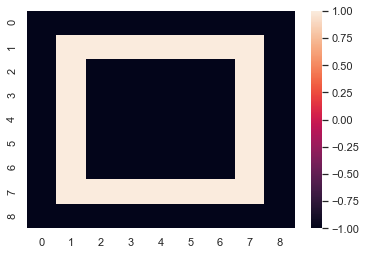

In [5]:
import numpy as np
import seaborn as sns; sns.set_theme()
b1 = sns.heatmap(bild1)

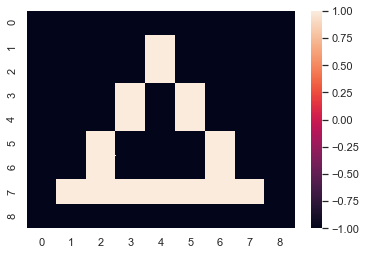

In [8]:
b2 = sns.heatmap(bild2)

In [9]:
for array in bild1:
    for pixel in array:
        print(pixel)

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
1
1
1
1
1
1
-1
-1
1
-1
-1
-1
-1
-1
1
-1
-1
1
-1
-1
-1
-1
-1
1
-1
-1
1
-1
-1
-1
-1
-1
1
-1
-1
1
-1
-1
-1
-1
-1
1
-1
-1
1
-1
-1
-1
-1
-1
1
-1
-1
1
1
1
1
1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
